# Dyna-Q

![title](dynaq_pic.png)

# Load Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# House Keeping

In [2]:
# Set a Seed
np.random.seed(802)

# Grid size
grid_rows = 6
grid_cols = 9

# Starting maze position
start = [2,0]

# Terminal state
goal = [0,8]

# Obstacles in the maze
walls = [ [1, 2], [2, 2], [3, 2], [4, 5], [0, 7], [1, 7], [2, 7] ]

# Action set 0=Up 1=Down 2=Left 3=Right
actions = range(4)

# Reward at Each Step
reward = 0

# Discount rate
gamma = 0.95

# Step Size
alpha = 0.1

# Exploration Rate
epsilon = 0.1

# Set number of episodes to run
episodes = 50

# Greedy Action Function

In [3]:
def greedy(state, q_table, epsilon):
    
    # Randomly select action with probability epsilon
    if np.random.uniform() < epsilon:
        g_action = np.random.choice(actions)
        
    # Select the best action for the given state with probability 1-epsilon
    else:
        q_vals = q_table[state[0], state[1], :]
        q_vals_max = np.where(q_vals==q_vals.max())[0]
        g_action = np.random.choice(q_vals_max)
    
    return g_action

# Step Function

In [4]:
def step(state, action):
    
    rownum, colnum = state
    
    # 0=Up
    if action==0:
        rownum = max( rownum - 1, 0 )
    
    # 1=Down
    elif action==1:
        rownum = min( rownum + 1, grid_rows - 1 )
    
    # 2=Left
    elif action==2:
        colnum = max( colnum - 1, 0 )
    
    # 3=Right
    else:
        colnum = min( colnum + 1, grid_cols - 1 )
    
    # Correct for walls
    if [rownum, colnum] in walls:
        rownum, colnum = state
    
    # Specify reward
    if [rownum, colnum] == goal:
        reward = 1
    else:
        reward = 0
    
    return [rownum, colnum], reward

# Q Table

In [5]:
q_table_ql = np.zeros([grid_rows, grid_cols, len(actions)])

# Q-Learning

In [6]:
# Store the steps to reach the goal for each episode
steps_vec_ql = []

# Q-Learning
for i in range(episodes):
    
    # Count steps per episode
    steps_count = 0
    
    # Always start in the same position
    state = start
    
    # Loop until the goal is reached
    while state!=goal:
        
        # Choose action based on epsilon-greedy
        action = greedy(state, q_table_ql, epsilon)
        
        # Find next state given current state and action
        new_state, reward = step(state, action)
        
        # Update the q-table with Q-Learning
        q_table_ql[state[0],state[1],action] = q_table_ql[state[0],state[1],action] + \
            alpha * ( reward + gamma * max(q_table_ql[new_state[0],new_state[1],]) - \
            q_table_ql[state[0],state[1],action] )
            
        # Set new state to current state
        state = new_state
        
        # Update steps count
        steps_count += 1
    
    # Save steps per episode
    steps_vec_ql.append(steps_count)

# Q Table and Evironment Model

In [7]:
q_table_dynaq = np.zeros([grid_rows, grid_cols, len(actions)])
model_dynaq = dict()

# Function to Sample State, Action and Reward, Next State Pairs

In [8]:
def sample_sars_pairs(model):
    
    # Sample random index 
    index_sample = np.random.choice(range(len(model)))
    
    # Find the pairs from the dictionary keys and values
    state_action = list(model.keys())[index_sample]
    newstate_reward = list(model.values())[index_sample]
    
    # Specify values to return
    state = [state_action[0], state_action[1]]
    action = state_action[2]
    new_state = [newstate_reward[0], newstate_reward[1]]
    reward = newstate_reward[2]
    
    return state, action, new_state, reward

# Dyna-Q

In [9]:
# Number of planning steps
n_planning_steps = 50

# Store the steps to reach the goal for each episode
steps_vec_dynaq = []

# Q-Learning
for i in range(episodes):
    
    # Count steps per episode
    steps_count = 0
    
    # Always start in the same position
    state = start
    
    # Loop until the goal is reached
    while state!=goal:
        
        # Choose action based on epsilon-greedy
        action = greedy(state, q_table_dynaq, epsilon)
        
        # Find next state given current state and action
        new_state, reward = step(state, action)
        
        # Update the q-table with Q-Learning
        q_table_dynaq[state[0],state[1],action] = q_table_dynaq[state[0],state[1],action] + \
            alpha * ( reward + gamma * max(q_table_dynaq[new_state[0],new_state[1],]) - \
            q_table_dynaq[state[0],state[1],action] )
        
        #####################################################################################
        
        # Create tuples to map environment
        state_action_key = tuple([state[0], state[1], action])
        newstate_reward_val = tuple([new_state[0], new_state[1], reward])

        # Add state, action, reward, new_state to model
        if state_action_key not in model_dynaq.keys():
            model_dynaq[state_action_key] = newstate_reward_val

        #####################################################################################
            
        # Set new state to current state
        state = new_state
        
        # Update steps count
        steps_count += 1
        
        # Conduct planning after the agent finds the goal the first time
        if i>0:
            
            # Update q_table with planning
            for j in range(n_planning_steps):
        
                # Sample state_action and reward_nextstate pair
                s_now, action, s_next, reward = sample_sars_pairs(model_dynaq)
        
                # Update the q-table
                q_table_dynaq[s_now[0],s_now[1],action] = q_table_dynaq[s_now[0],s_now[1],action] + \
                    alpha * ( reward + gamma * max(q_table_dynaq[s_next[0],s_next[1],]) - \
                    q_table_dynaq[s_now[0],s_now[1],action] )
    
    # Save steps per episode
    steps_vec_dynaq.append(steps_count)

# View Q-Learning Results

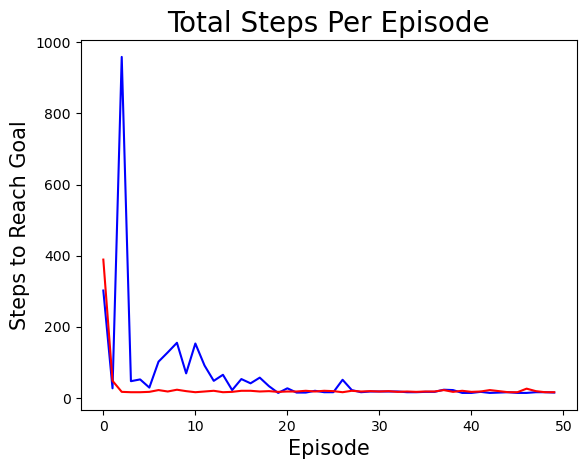

In [10]:
plt.plot(steps_vec_ql, color="blue")
plt.plot(steps_vec_dynaq, color="red")
plt.title("Total Steps Per Episode", fontsize=20)
plt.xlabel("Episode", fontsize=15)
plt.ylabel("Steps to Reach Goal", fontsize=15)
plt.show()